In [12]:
from torchvision import utils
from transfer_resnet import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

In [2]:
batch = 3
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)

In [3]:
# # Inspect DataLoader objects
# print("Number of training examples:", len(train_dataset))
# print("Number of validation examples:", len(val_dataset))
# print("Number of test examples:", len(test_dataset))

In [4]:
# # Look at a dataset data
# example = train_dataset[0]
# print("Training set example image file:", train_dataset.data.iloc[0][0])
# print("Training set example label file:", train_dataset.data.iloc[0][1])
# print("Size of the image tensor:", example[0].size())
# print("Size of the one-hot target tensor:", example[1].size())
# print("Size of the label tensor:", example[2].size())
# print(example[2])

In [5]:
# for i_batch, sample_batched in enumerate(train_loader):
#     print(sample_batched[0].size())
#     print(sample_batched[1].size())
#     print(sample_batched[2].size())
#     break

In [6]:

# list(trans_model.children())
# print(trans_model)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.xavier_uniform_(m.bias.data.unsqueeze(0)) #add unsqueeze here 
        
epochs     = 15
learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
trans_model = TransResNet(n_class=n_class)
trans_model.initialize_weights(init_weights)
#fcn_model = torch.load('best_model')
optimizer = optim.Adam(trans_model.parameters(), lr=learning_rate)

In [8]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    trans_model = trans_model.cuda()
    
def train():
    t_losses = []
    t_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, epochs+1):
        print("Training Epoch {}".format(epoch))
        ts = time.time()
        
        numIter = 0
        epoch_train_loss = 0
        epoch_train_acc = 0
        
        for iter, (X, _, Y) in enumerate(train_loader):
            numIter +=1
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
#                 oneHotLabels = tar.cuda()
            else:
                inputs, labels = X, Y # Unpack variables into inputs and labels

            outputs = trans_model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            
#             if iter > 0:
#                 print('Batch #' + str(iter) + ' training error: ' + str(loss.item()))
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            epoch_train_acc += pixel_acc(indexes, labels) 
            
            loss.backward()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
            #'''
            if iter == 100:
                break
            #'''
            
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        del inputs, labels, outputs, loss, indexes, speakSoftlyAndCarryABigStick
        torch.cuda.empty_cache()     
        #torch.save(fcn_model, 'best_model')
        print()
        
        t_losses.append(epoch_train_loss/numIter)
        t_accuracies.append(epoch_train_acc/numIter)
        
        val_loss, val_acc = val(epoch)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        trans_model.train()
    return t_losses, t_accuracies, val_losses, val_accuracies

def val(epoch):
    print("Validation Epoch {}".format(epoch))
    trans_model.eval()
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    valLoss = 0
    valAcc = 0
    numIter = 0
    ts = time.time()
    for iter, (X, _, Y) in enumerate(val_loader):
            numIter +=1
            if use_gpu:
                torch.cuda.empty_cache() 
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
#                 oneHotLabels = tar.cuda()
            else:
                inputs, labels = X, Y # Unpack variables into inputs and labels
            
            outputs = trans_model(inputs)
            valLoss += criterion(outputs, labels).item()   
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            
            '''
            #Only use for one batch
            
            print("Model output size (not one-hot encoded):", indexes.size())
            print(indexes)
            print("Original label size (not one-hot encoded):", labels.size())
            print(labels)
            print()
            print("Model output size for channel 30 (one-hot encoded):", goGoGadgetSkis.size())
            print(goGoGadgetSkis[0][30])
            print("Original label size for channel 30 (one-hot encoded):", oneHotLabels.size())
            print(oneHotLabels[0][30])
            print()
            '''

            valAcc += pixel_acc(indexes, labels)        
            
            #manage memory again...
            del inputs, labels, outputs, indexes, speakSoftlyAndCarryABigStick
            torch.cuda.empty_cache()            
            
            #'''
            if iter == 20:
                break
            #'''
            
    valAcc = valAcc/numIter
    valLoss = valLoss/numIter
    print("epoch{}, validation loss: {}".format(epoch, valLoss))
    print("epoch{}, validation accuracy: {}".format(epoch, valAcc))
    print("Finish validation at epoch{}, time elapsed {}".format(epoch, time.time() - ts))
    print()
    return valLoss, valAcc
    
def test():
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1)
    
if __name__ == "__main__":
    val(0)  # show the accuracy before training
    training_losses, training_accuracies, validation_losses, validation_accuracies = train()

Validation Epoch 0
epoch0, validation loss: 3.527842328661964
epoch0, validation accuracy: 3.239292568630642
Finish validation at epoch0, time elapsed 19.591153860092163

Training Epoch 1
epoch1, iter0, loss: 3.4973859786987305
epoch1, iter100, loss: 1.3981289863586426
Finish epoch 1, time elapsed 75.12097191810608

Validation Epoch 1
epoch1, validation loss: 1.4899026609602428
epoch1, validation accuracy: 64.44014443291559
Finish validation at epoch1, time elapsed 21.571533679962158

Training Epoch 2
epoch2, iter0, loss: 2.859527826309204
epoch2, iter100, loss: 1.2168984413146973
Finish epoch 2, time elapsed 77.411691904068

Validation Epoch 2
epoch2, validation loss: 1.266342009816851
epoch2, validation accuracy: 70.24309748695008
Finish validation at epoch2, time elapsed 22.2294180393219

Training Epoch 3
epoch3, iter0, loss: 1.0384420156478882
epoch3, iter100, loss: 1.1731828451156616
Finish epoch 3, time elapsed 73.64221048355103

Validation Epoch 3
epoch3, validation loss: 1.0722

In [9]:
print(training_losses)
print(training_accuracies)
print(validation_losses)
print(validation_accuracies)

[7.975638717708021, 1.7187529105951291, 1.2509735551210914, 1.0578822759118411, 1.028281262015352, 0.9688759286804954, 0.9068804471799643, 0.877395498280478, 0.8413033532624198, 0.8501270985839391, 0.850026276442084, 0.8322746582550578, 0.790505718181629, 0.8265484701288809, 0.7963420548061333]
[46.08651671079124, 62.724411054806325, 69.35001615643893, 73.65619624801988, 73.74284715935735, 74.84779121852158, 76.15675060662498, 76.63912112169928, 77.54833517294902, 76.94294570696235, 76.82804667910332, 77.40838346701645, 78.41118774791752, 77.52772510641876, 77.92368816463863]
[1.4899026609602428, 1.266342009816851, 1.0722641944885254, 0.9974027105740139, 0.8626991709073385, 0.9135913252830505, 0.9438171471868243, 0.9090085483732677, 0.8532511109397525, 0.7528614699840546, 0.7954604625701904, 0.8407395822661263, 0.8240142038890294, 0.8571108551252455, 0.7763912904830206]
[64.44014443291559, 70.24309748695008, 73.82092551579551, 74.81383747524686, 77.8370251731267, 76.56364289541094, 75.

In [47]:
import os
fname = os.path.join('models', 'resnet18_epoch' + str(epochs) + '_lr' + "{:.0e}".format(learning_rate))
save(trans_model, os.path.join('Saved Models', fname +'.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'Saved Models/models/resnet18_epoch15_lr5e-04.pt'

In [45]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Losses')
ax.set_xlabel('Epochs')
_=ax.plot(range(1, epochs+1), training_losses,'b-',color="blue",label="train")
_=ax.plot(range(1, epochs+1), validation_losses,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")
plt.savefig(os.path.join('Plots', fname + '_loss.png')

SyntaxError: unexpected EOF while parsing (<ipython-input-45-cc3e902c8fad>, line 8)

Text(0.5, 1.0, 'Accuracy on training set and holdout set vs. number of epochs')

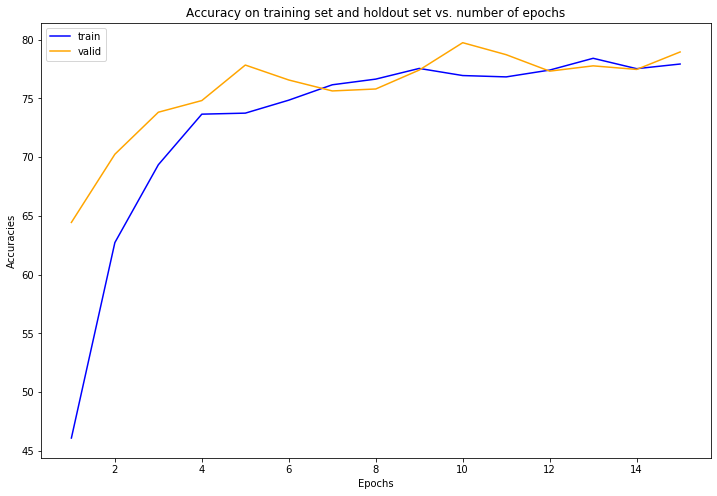

In [11]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epochs')
_=ax.plot(range(1, epochs+1), training_accuracies,'b-',color="blue",label="train")
_=ax.plot(range(1, epochs+1), validation_accuracies,'b-',color="orange",label="valid")
plt.legend()
plt.title("Accuracy on training set and holdout set vs. number of epochs")
plt.savefig(os.path.join('Plots', fname + '_accuracy.png')

In [43]:
from torch import save
# Save the model


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type TransResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/pyt

In [41]:
os.getcwd()

'/home/kkalhor/CSE253/PA3/github-pulls/PA3'

In [36]:
learning_rate = 0.5e-3

'models/resnet18_epoch15_lr5e-04'

In [34]:
import os